# INTRO

In [1]:
%matplotlib inline

## ML PROJECT WORKFLOW
With Scikit Learn

![](./img/proj_workflow_sklearn_mapping.png)

---

## Riprendiamo

1. Carichiamo il dataset IRIS
2. Suddividiamo in Train e Test dataset
3. Applichiamo il preprocessing necessario alle labels

In [2]:
import pandas as pd
import numpy as np

#### 1. Carichiamo il dataset IRIS

In [3]:
from sklearn import datasets
iris = datasets.load_iris() # https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-plants-dataset

iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df["target_num"] = iris.target
iris_df["target_class"] = iris_df["target_num"].apply(lambda x: iris.target_names[x])
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target_num,target_class
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


#### 2. Suddividiamo in Train e Test dataset

In [4]:
from sklearn.model_selection import train_test_split

X = iris_df[iris.feature_names]
y = iris_df["target_class"]

#### suddivisione in train dataset e test dataset per classificazione multiclasse
X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42) 

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((105, 4), (45, 4), (105,), (45,))

In [5]:
y_train.value_counts()

versicolor    35
setosa        35
virginica     35
Name: target_class, dtype: int64

In [6]:
y_test.value_counts()

virginica     15
versicolor    15
setosa        15
Name: target_class, dtype: int64

#### 3. Applichiamo il preprocessing necessario alle labels

In [7]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder # transformers for labels (y)

le = LabelEncoder()

y_train_le = pd.Series(le.fit_transform(y_train), index=y_train.index)
y_test_le = pd.Series(le.transform(y_test), index=y_test.index)

y_train_le.shape, y_test_le.shape

((105,), (45,))

In [8]:
y_train[:10]

98     versicolor
68     versicolor
19         setosa
143     virginica
99     versicolor
145     virginica
9          setosa
46         setosa
8          setosa
102     virginica
Name: target_class, dtype: object

In [9]:
y_train_le[:10]

98     1
68     1
19     0
143    2
99     1
145    2
9      0
46     0
8      0
102    2
dtype: int32

## Pipeline
Utilities to build a composite estimator, as a chain of transforms and estimators.

Vediamo ora le Pipeline che ci permettono di astrarre i vari step del training.

Come accennato le volte precedenti: il training non è solo l'addestramento del modello ma è anche la trasformazione delle features (oppure le definizione di nuove).

Le Pipeline ci permettono di applicare *sequenzialmente* una lista di operazioni (*transformers*) seguete da un *estimator*.
Quindi:
- Gli step iniziali devono implementare i metodi *fit* e *transform*
- Lo step finale deve implementare solo il metodo *fit* (ed eventualmente *predict*)

I vantaggi sono:
- utilizzo di un solo oggetto
- è passare un blocco unico di parametri ma che afferiscono a step diversi della pipeline (utile per tuning dei parametri)

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier


# definizione del transformer (scaler)
scaler = StandardScaler()

# definizione del estimator (classficatore multiclasse)
clf = OneVsRestClassifier(estimator=SVC(random_state=42))

# creazione della pipeline
pipe = Pipeline(steps=[
    ("scaler", scaler), 
    ("ovr_classifier", clf)
])

In [11]:
pipe[0]

StandardScaler()

In [12]:
pipe["scaler"]

StandardScaler()

*fit* della pipeline

In [13]:
%%time
pipe.fit(X_train, y_train_le)

Wall time: 21.5 ms


Pipeline(steps=[('scaler', StandardScaler()),
                ('ovr_classifier',
                 OneVsRestClassifier(estimator=SVC(random_state=42)))])

*predict*

In [14]:
y_pred_pipe = pipe.predict(X_test)
y_pred_pipe[:10]

array([2, 1, 1, 1, 2, 2, 1, 1, 0, 2])

In [15]:
y_test_le[:10].values

array([2, 1, 2, 1, 2, 2, 1, 1, 0, 2])

#### Pipeline parameters
I parametri dei singoli transformers / estimators all'interno di una pipeline si possono leggere / modificare con la sintassi `<estimator>__<parameter>`.

Alcuni passaggi possono anche essere esclusi usando la parola chiave `'passthrough'`.

Questo è molto utile in fase di HyperParameter Tuning, ovvero: una volta selezionato i migliori modelli li si ottimizza cercando di migliorare ulteriormente le loro performance.  

In [16]:
pipe.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('ovr_classifier', OneVsRestClassifier(estimator=SVC(random_state=42)))],
 'verbose': False,
 'scaler': StandardScaler(),
 'ovr_classifier': OneVsRestClassifier(estimator=SVC(random_state=42)),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'ovr_classifier__estimator__C': 1.0,
 'ovr_classifier__estimator__break_ties': False,
 'ovr_classifier__estimator__cache_size': 200,
 'ovr_classifier__estimator__class_weight': None,
 'ovr_classifier__estimator__coef0': 0.0,
 'ovr_classifier__estimator__decision_function_shape': 'ovr',
 'ovr_classifier__estimator__degree': 3,
 'ovr_classifier__estimator__gamma': 'scale',
 'ovr_classifier__estimator__kernel': 'rbf',
 'ovr_classifier__estimator__max_iter': -1,
 'ovr_classifier__estimator__probability': False,
 'ovr_classifier__estimator__random_state': 42,
 'ovr_classifier__estimator__shrinking': True,
 'ovr_classifier__estimator__tol': 0.001,
 'ovr_classifier_

In [17]:
pipe.set_params(ovr_classifier__estimator__kernel='linear')

Pipeline(steps=[('scaler', StandardScaler()),
                ('ovr_classifier',
                 OneVsRestClassifier(estimator=SVC(kernel='linear',
                                                   random_state=42)))])

In [18]:
pipe.set_params(scaler='passthrough')

Pipeline(steps=[('scaler', 'passthrough'),
                ('ovr_classifier',
                 OneVsRestClassifier(estimator=SVC(kernel='linear',
                                                   random_state=42)))])

*fit* della pipeline

In [19]:
%%time
pipe.fit(X_train, y_train_le)

Wall time: 28.1 ms


Pipeline(steps=[('scaler', 'passthrough'),
                ('ovr_classifier',
                 OneVsRestClassifier(estimator=SVC(kernel='linear',
                                                   random_state=42)))])

*predict*

In [20]:
y_pred_pipe_2 = pipe.predict(X_test)
y_pred_pipe_2[:10]

array([2, 1, 1, 2, 2, 2, 1, 1, 0, 2])

In [21]:
y_test_le[:10].values

array([2, 1, 2, 1, 2, 2, 1, 1, 0, 2])

## Metrics
Metrics and scoring to quantify the quality of predictions.
It includes score functions, performance metrics and pairwise metrics and distance computations.


### Confusion Matrix
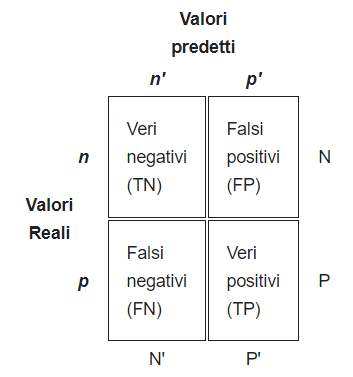

### Accuracy
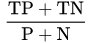

### Precision
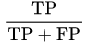

### Recall
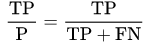

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score

##### metriche per prima pipeline

In [23]:
cm = confusion_matrix(y_test_le.values, y_pred_pipe)
cm

array([[15,  0,  0],
       [ 0, 14,  1],
       [ 0,  3, 12]], dtype=int64)

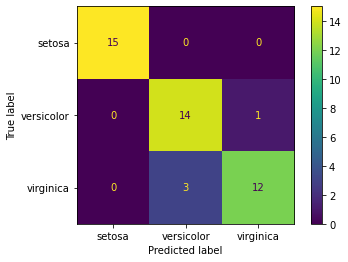

In [24]:
ConfusionMatrixDisplay(cm, display_labels=le.classes_).plot()

In [25]:
print(classification_report(y_test_le.values, y_pred_pipe))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.82      0.93      0.87        15
           2       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45



In [26]:
accuracy_score(y_test_le.values, y_pred_pipe)

0.9111111111111111

In [27]:
precision_score(y_test_le.values, y_pred_pipe, average="weighted")

0.9155354449472096

In [28]:
recall_score(y_test_le.values, y_pred_pipe, average="weighted")

0.9111111111111111

##### metriche per seconda pipeline

In [29]:
cm = confusion_matrix(y_test_le.values, y_pred_pipe_2)
cm

array([[15,  0,  0],
       [ 0, 12,  3],
       [ 0,  3, 12]], dtype=int64)

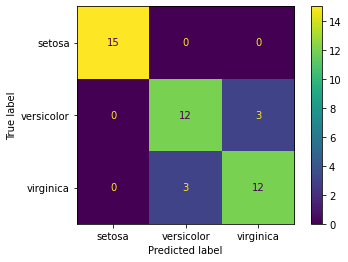

In [30]:
ConfusionMatrixDisplay(cm, display_labels=le.classes_).plot()

In [31]:
print(classification_report(y_test_le.values, y_pred_pipe_2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.80      0.80      0.80        15
           2       0.80      0.80      0.80        15

    accuracy                           0.87        45
   macro avg       0.87      0.87      0.87        45
weighted avg       0.87      0.87      0.87        45



In [32]:
accuracy_score(y_test_le.values, y_pred_pipe_2)

0.8666666666666667

In [33]:
precision_score(y_test_le.values, y_pred_pipe_2, average="weighted")

0.8666666666666667

In [34]:
recall_score(y_test_le.values, y_pred_pipe_2, average="weighted")

0.8666666666666667